In [ ]:
##########################################################################################################
#   For the task of segmentation we will be using only malignant and benign classes as the mask for      #
#   normal ultrasound will be zero always (probably!!)                                                   #
#                                                                                                        #
#   Model Used: U-Net                                                                                    #
##########################################################################################################

# Constants

In [1]:
LOAD_MODEL = True
NUMBER_OF_EPOCHS = 1
I_WANT_TO_TRAIN = True

# Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras

# Data Loader

In [3]:
# Defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData(frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [4]:
# Loading benign samples
local_path = "../Dataset_BUSI_with_GT/"

framObjTrain = LoadData( framObjTrain, imgPath = local_path + 'benign'
                        , maskPath = local_path + 'benign'
                         , shape = 256)

In [5]:
# Loading malignant samples
local_path = "../Dataset_BUSI_with_GT/"

framObjTrain = LoadData( framObjTrain, imgPath = local_path + 'malignant'
                        , maskPath = local_path + 'malignant'
                         , shape = 256)

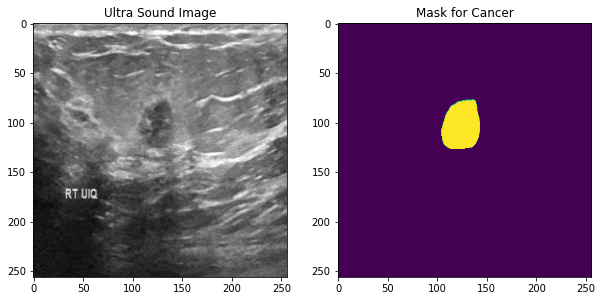

In [6]:
# Displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][100])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][100])
plt.title('Mask for Cancer')
plt.show()

# Model Definition

In [7]:
# This block essentially performs 2 convolution
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    # First Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    # Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # Defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # Defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

# Model Instantiation

In [8]:
if LOAD_MODEL:
    # Load a model that's trained already
    model = keras.models.load_model('BreastCancerSegmentor_21-05-2021_08-53-40.h5')
else:
    # Create new model
    inputs = tf.keras.layers.Input((256, 256, 3))
    myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
    myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
    model = myTransformer

# Training

In [9]:
if I_WANT_TO_TRAIN:
    retVal = model.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = NUMBER_OF_EPOCHS, verbose = 1)

21/21 [==============================] - 267s 13s/step - loss: 0.0990 - accuracy: 0.9645


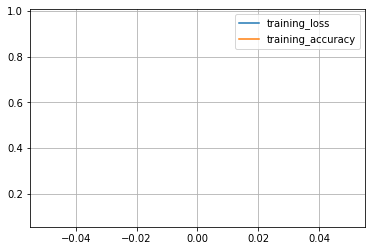

In [10]:
if retVal:
    plt.plot(retVal.history['loss'], label = 'training_loss')
    plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
    plt.legend()
    plt.grid(True)

# Testing

In [11]:
def predict(valMap, model, shape = 256):
    # Getting and proccessing val data
    # Benign: 437
    # Malignant: 210
    # Limit: don't predict all to speed up a bit
    limit = 20
    img = valMap['img'][0:limit]
    mask = valMap['mask'][0:limit]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

In [12]:
my_prediction, my_actuals, my_masks = predict(framObjTrain, model)

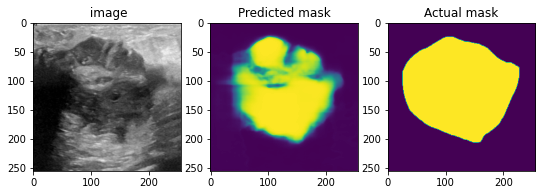

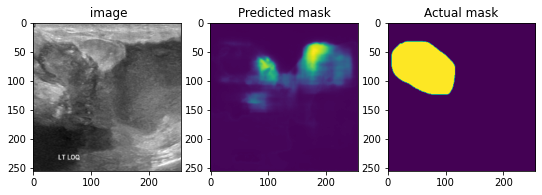

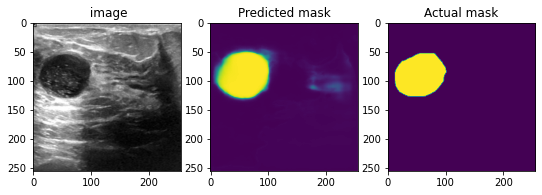

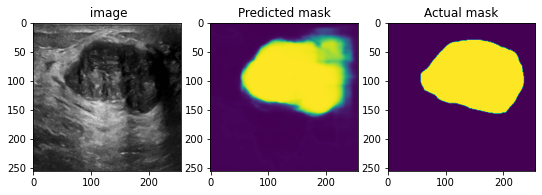

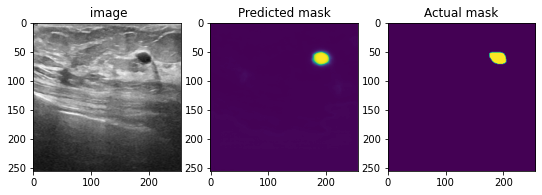

In [13]:
for idx in range(5):
    Plotter(my_actuals[idx], my_prediction[idx][:,:,0], my_masks[idx])

# Saving Model

In [14]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
mod_name = 'BreastCancerSegmentor_' + dt_string + '.h5'
model.save(mod_name)
print('Model saved as ' + mod_name)

Model saved as BreastCancerSegmentor_21-05-2021_13-38-11.h5


# Calculate Accuracy

In [15]:
def calc_accuracy(predictions, masks):
    predictions = predictions.flatten()
    masks = masks.flatten()
    idx = 0
    inter = 0
    union = 0
    accuracy = 0
    # threshold = 0.5  
    threshold = np.max(predictions) / 2
    
    for pred in predictions:
        mask = masks[idx]
        if mask > threshold and pred > threshold:
            inter += 1
        if mask > threshold or pred > threshold:
            union += 1
        if int(round(pred)) == int(round(mask)):
            accuracy += 1
        idx += 1
    
    iou = inter / union
    accuracy = accuracy / 256**2
    return accuracy

image_index = 3
calc_accuracy(my_prediction[image_index], my_masks[image_index])

0.9604339599609375

In [16]:
# from tensorflow import keras
# model = keras.models.load_model('BreastCancerSegmentor_21-05-2021_08-53-40.h5')

In [17]:
# my_prediction, my_actuals, my_masks = predict(framObjTrain, model)
# Plotter(my_actuals[1], my_prediction[1][:,:,0], my_masks[1])